# Tutorial: Education & Opportunity in English Towns 🎓

### A Guide to Data Visualisation with Seaborn

**Goal:** Learn how to create and interpret data visualisations using Seaborn. We will move from simple, single-variable plots to complex, multi-variable insights.

**Core Dataset:** Educational Attainment of Young People in English Towns ([TidyTuesday 2024-01-23](https://github.com/rfordatascience/tidytuesday/blob/main/data/2024/2024-01-23/readme.md))

**Business Context:** We are consultants for the UK's Department for Education. Our goal is to analyse this dataset to answer the ONS's key question: **"What factors and town characteristics are associated with better educational outcomes for young people?"**

### Task 0: Setup and First Look

**Concept:** Before you can visualise, you must understand your data's structure.

**Instructions:** Run the code in the cell below to import libraries, load our dataset, and take a first look. We'll show two ways to load the data.

**Note:** the `pydytuesday` package will not be installed by default. So you need to install it first using the code below.

In [1]:
!pip install -Uqq pydytuesday beautifulsoup4 # <-- you can install any package you want using this syntax. You will need to restart the kernel to load the package once it is done.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import pydytuesday
import os

# Set a nice default style for all plots
sns.set_theme(style="whitegrid")

# Suppress warnings
warnings.filterwarnings('ignore')

# --- Method 1: Using pydytuesday (as requested) ---
# This command downloads the files for this week into your current directory
print("Downloading data using pydytuesday...")
try:
    pydytuesday.get_date('2024-01-23')
    file_path = 'english_education.csv'
    # Check if the file was successfully downloaded
    if not os.path.exists(file_path):
        raise FileNotFoundError("pydytuesday download failed, falling back to URL.")
    print(f"Successfully downloaded {file_path}")
    edu_data = pd.read_csv(file_path)

except Exception as e:
    print(f"pydytuesday method failed ({e}). Using direct URL method.")
    # --- Method 2: Load directly from URL (More robust for this tutorial) ---
    data_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2024/2024-01-23/english_education.csv'
    edu_data = pd.read_csv(data_url)

print("\n--- First 5 Rows ---")
print(edu_data.head())
print("\n--- Statistical Summary ---")
print(edu_data.describe())

/home/francis2.donkor/.local/lib/python3.13/site-packages/bs4/css.py:40: UserWarning: The soupsieve package is not installed. CSS selectors cannot be used.
  warnings.warn(


Trying to fetch README from: https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2024/2024-01-23/readme.md
Successfully fetched README from: https://raw.githubusercontent.com/rfordatascience/tidytuesday/refs/heads/main/data/2024/2024-01-23/readme.md
Successfully saved english_education.csv to /home/francis2.donkor/Data Visualisation/english_education.csv
Successfully saved pic1.png to /home/francis2.donkor/Data Visualisation/pic1.png
Successfully saved pic2.png to /home/francis2.donkor/Data Visualisation/pic2.png
Successfully saved post_vars.json to /home/francis2.donkor/Data Visualisation/post_vars.json
Successfully downloaded english_education.csv

--- First 5 Rows ---
    town11cd                      town11nm  population_2011    size_flag  \
0  E34000007       Carlton in Lindrick BUA           5456.0  Small Towns   
1  E34000016  Dorchester (West Dorset) BUA          19060.0  Small Towns   
2  E34000020                       Ely BUA          19090.0  

**Interpretation:**

* `edu_data.head()` shows our columns. We have many!

* **Key Columns:** `education_score` (our main KPI), `size_flag` (town size), `income_flag` (deprivation), `coastal`, `university_flag`.

* `edu_data.describe()` gives us a summary of the numeric columns. We see the `education_score` has a mean of 0.0, which means it's a *standardised score* (a z-score). -1 is one standard deviation *below* the average, +1 is one *above*.

### Task 1: Understanding a Single Variable (Univariate Analysis)

**Concept:** What does one variable look like by itself? We'll start with our main KPI.

**BI Question:** "What is the distribution of the `education_score` across English towns?"

**Plot:** `histplot()` - This shows the *distribution* of our data.

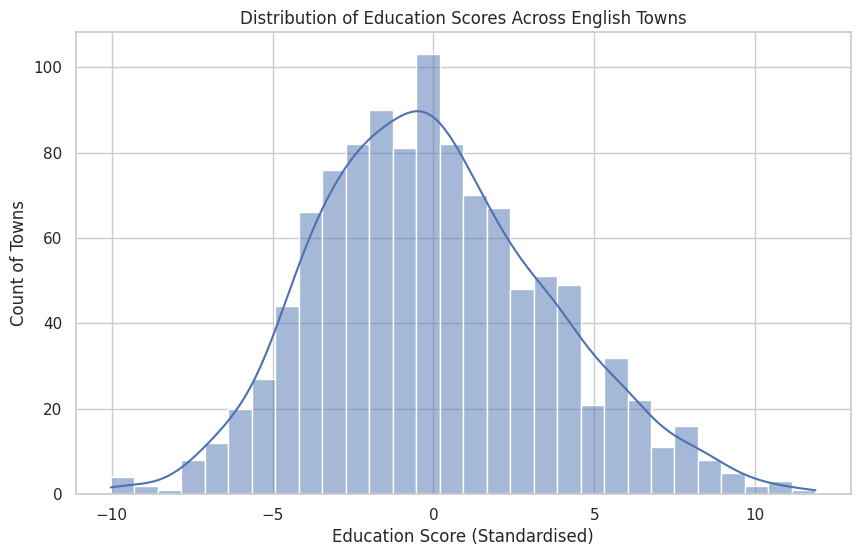

In [8]:
plt.figure(figsize=(10, 6))
#KDE is the smooth line on the histogram
sns.histplot(data=edu_data, x="education_score", kde=True, bins=30) 
plt.title("Distribution of Education Scores Across English Towns")
plt.xlabel("Education Score (Standardised)")
plt.ylabel("Count of Towns")
plt.show()

**Interpretation:**

* The distribution is fairly normal, centered around 0 (as expected).

### Task 2: Comparing Groups (Bivariate Analysis: Categorical vs. Numeric)

**Concept:** This is the core of the ONS article. Does town size matter?

**BI Question:** "How does educational attainment (`education_score`) differ by the `size_flag` (town size)?"

**Plot:** `boxplot()` - Perfect for comparing distributions across categories.

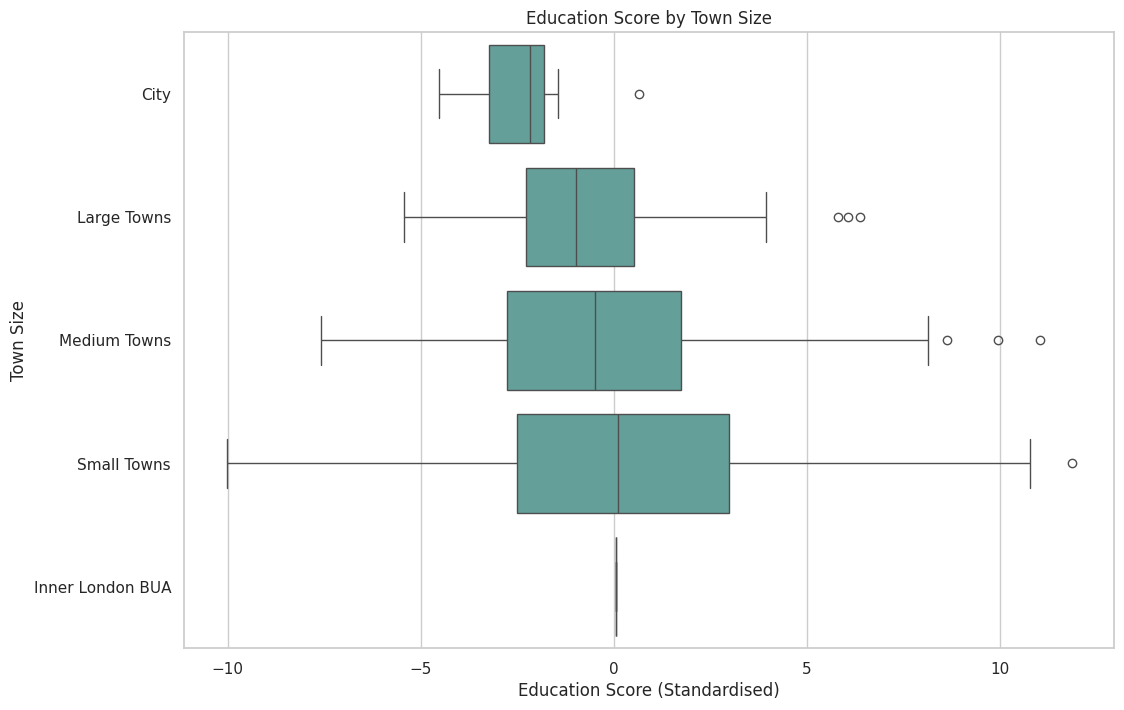

In [21]:
# Get the unique categories and define a logical order
# Using the correct values you provided:
size_order = [
    'City', 
    'Large Towns', 
    'Medium Towns', 
    'Small Towns',
]

# Filter data to only include these categories
# Specifically it is only showing the variables that are in size_order
filtered_edu_data = edu_data[edu_data['size_flag'].isin(size_order)]


plt.figure(figsize=(12, 8))
# We put the categorical variable on the 'y' axis to make the labels easy to read
sns.boxplot(data=filtered_edu_data, 
            y="size_flag", 
            x="education_score", 
            order=size_order,
            color="#5AA9A2",
            )
plt.title("Education Score by Town Size")
plt.xlabel("Education Score (Standardised)")
plt.ylabel("Town Size")
plt.show()

**Interpretation:**

* This plot reproduces the ONS article's main finding!

* **BI Insight:** "`City`" towns have the tightest and lowest-scoring distribution. As towns get smaller (`Large` -> `Medium` -> `Small`), the median score increases and the distribution gets wider.

* **Small towns are not just *higher* performing on average, but the scores vary more and are less consistent (more variance).** This is a key insight for the Department for Education.

### Task 3: Cleaning & Bivariate Analysis (Numeric vs. Numeric)

**Concept:** What other town characteristics are related to educational outcomes? We must clean our data first.

**BI Question:** "Are towns with more highly-educated adults more likely to have better outcomes for their children?"

**Plot:** `regplot()` (Regression Plot)

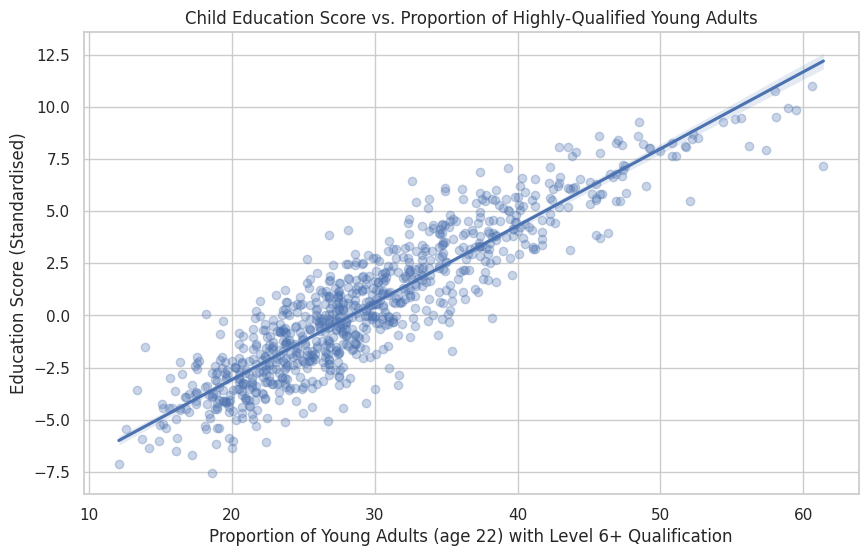

In [25]:
# 1. Clean the Data
# Turns the string into float or integer
edu_data['young_adult_qual_prop'] = pd.to_numeric(
    edu_data['highest_level_qualification_achieved_by_age_22_level_6_or_above'],
    errors='coerce' # If any errors, turn them into 'Not a Number'
)

# Drop rows where we couldn't get the qualification data
#Subset is used in this case as it is only looking at removing rows from these two specific columns
clean_data = edu_data.dropna(subset=['young_adult_qual_prop', 'education_score'])

# 2. Plot the relationship
plt.figure(figsize=(10, 6))
sns.regplot(data=clean_data, 
            x="young_adult_qual_prop", 
            y="education_score",
            scatter_kws={'alpha':0.3}) # Make points transparent
plt.title("Child Education Score vs. Proportion of Highly-Qualified Young Adults")
plt.xlabel("Proportion of Young Adults (age 22) with Level 6+ Qualification")
plt.ylabel("Education Score (Standardised)")
plt.show()

**Interpretation:**

* **Key Term:** There is a very strong **positive correlation**.

* **BI Insight:** Towns with a higher proportion of highly-educated young adults are *far* more likely to have high education scores for their children. This suggests that socio-economic factors and existing educational capital in a community are massive drivers of outcomes.

### Task 4: Bringing It All Together (Multivariate Analysis)

**Concept:** Let's combine our findings. Does the socio-economic factor (Task 3) explain the town-size finding (Task 2)?

**BI Question:** "We know adult qualifications matter. Does this relationship change based on a town's `income_flag` (deprivation level)?"

**Plot:** `lmplot()` - The perfect tool for this.

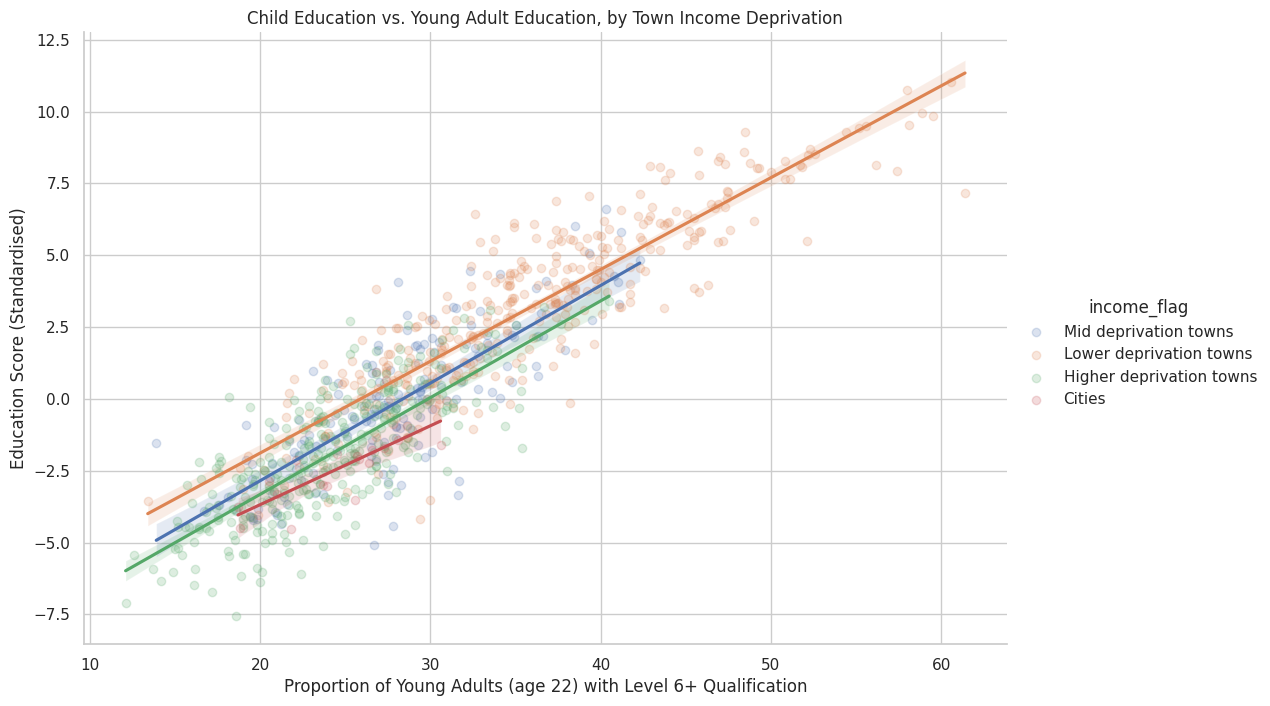

In [10]:
# lmplot is a Figure-level function, so we use it directly
sns.lmplot(data=clean_data, 
           x="young_adult_qual_prop", 
           y="education_score", 
           hue="income_flag", # <-- This is the magic!
           height=7, 
           aspect=1.5,
           scatter_kws={'alpha':0.2})
plt.title("Child Education vs. Young Adult Education, by Town Income Deprivation")
plt.xlabel("Proportion of Young Adults (age 22) with Level 6+ Qualification")
plt.ylabel("Education Score (Standardised)")
plt.show()

**Interpretation:**

* **Key BI Insight:** This is a powerful, story-telling chart.

* We now have four distinct regression lines, one for each income group.

* **Lower deprivation towns** (orange line) start higher and also have the highest proportion of highly educated adults.

* **Mid deprivation towns** (blue line) have the second highest scores as well as proportion of highly educated adults.

* **Highter deprivation towns** (green line) have even fewer highly educated adults and thus education scores.

* Finally, **Cities** have the lowest education scores as well as lowest proportion of highly educated adults.

* **This means that even for the *same* proportion of highly-educated young adults, a town with 'Higher income deprivation' will have a lower education score.** The socio-economic context of the town itself has a massive effect, *on top of* the effect from individual households.

**Note:** Income deprivation includes adults that are both unemployed as well as have those that are employed but have low earnings.

### Task 5: The 10,000-Foot View (Matrix Plots)

**Concept:** Let's create a powerful summary for a presentation.

**BI Question:** "Give me a one-glance summary of all the key drivers of the `education_score`."

**Plot:** `heatmap()` (Correlation Matrix)

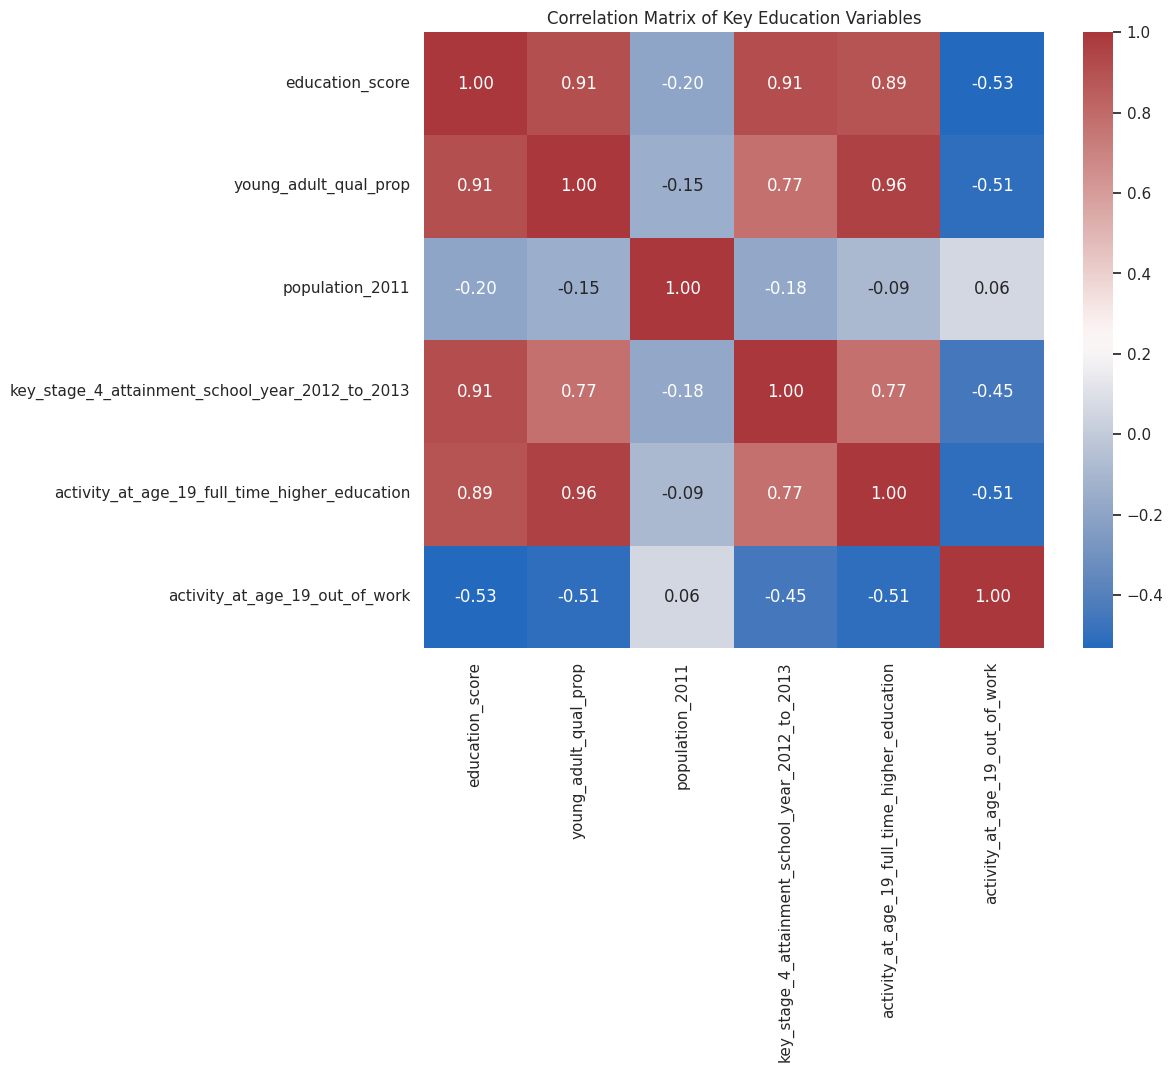

In [11]:
# 1. Select the key numeric columns we're interested in
key_vars = [
    'education_score',
    'young_adult_qual_prop',
    'population_2011',
    'key_stage_4_attainment_school_year_2012_to_2013',
    'activity_at_age_19_full_time_higher_education',
    'activity_at_age_19_out_of_work'
]
corr_data = clean_data[key_vars].corr()

# 2. Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_data, 
            annot=True,     # Show the numbers in the cells
            fmt='.2f',      # Format to 2 decimal places
            cmap="vlag")    # Use a diverging colour map
plt.title("Correlation Matrix of Key Education Variables")
plt.show()

**Interpretation:**

* This is our "cheat sheet" for a business presentation.

* **BI Insight:**

  * `education_score` is *very* positively correlated with `young_adult_qual_prop`, `key_stage_4_attainment_school_year_2012_to_2013` (0.91), and `activity_at_age_19_full_time_higher_education` (0.89). This makes sense - they all measure "good" outcomes.

  * `education_score` is *very* negatively correlated with `activity_at_age_19_out_of_work` (-0.53). This links poor scores to poor employment outcomes.

  * `population_2011` (a proxy for size) has a *negative* correlation (-0.20) with `education_score`, confirming our finding from Task 2.

### Task 6: Exploring Other Key Characteristics

**Concept:** We've seen that town size and income levels matter. What about other simple flags?

**BI Question:** "Do towns with a university, or towns that are coastal, have different educational outcomes?"

**Plot:** `violinplot()` - This plot is excellent as it combines a `boxplot` with a `kdeplot` (density curve), showing us the *shape* of the distribution.

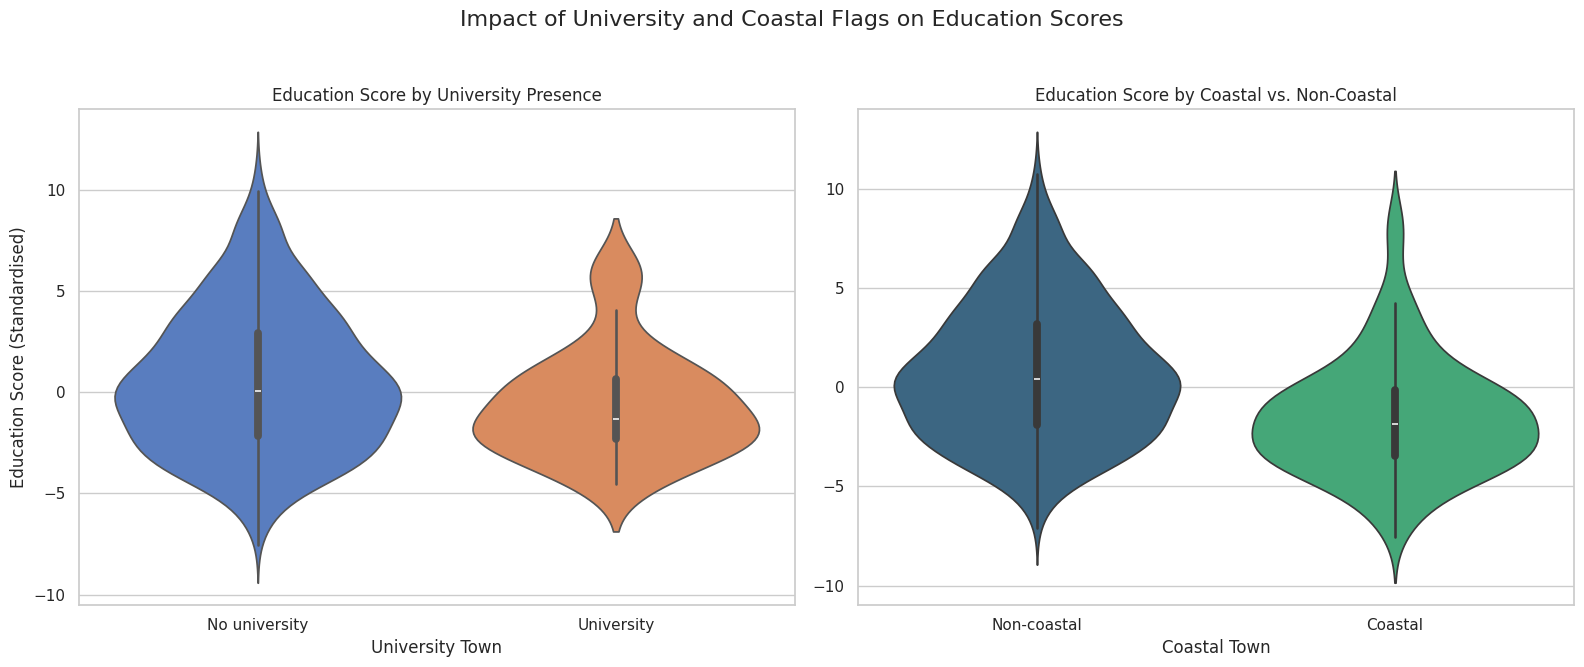

In [12]:
# We can create two plots side-by-side using matplotlib's subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: University Flag
sns.violinplot(data=clean_data, 
               x="university_flag", 
               y="education_score", 
               ax=axes[0],
               palette="muted")
axes[0].set_title("Education Score by University Presence")
axes[0].set_xlabel("University Town")
axes[0].set_ylabel("Education Score (Standardised)")

# Plot 2: Coastal Flag
sns.violinplot(data=clean_data, 
               x="coastal", 
               y="education_score", 
               ax=axes[1],
               palette="viridis")
axes[1].set_title("Education Score by Coastal vs. Non-Coastal")
axes[1].set_xlabel("Coastal Town")
axes[1].set_ylabel("") # No y-label as it's shared

plt.suptitle("Impact of University and Coastal Flags on Education Scores", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
plt.show()

**Interpretation:**

*Write your interpretations here:*

__

**Note:** Try and find a reason for your interpretation by exploring the dataset on your own.

### Task 7: The "All-in-One" Dashboard Plot

**Concept:** We've built our understanding plot-by-plot. The final step is to use a powerful tool, the `pairplot()`, which creates a grid showing *every* pairwise relationship for a set of variables.

**BI Question:** "Show me a high-level summary of how our key numeric drivers relate to each other, and how `income_flag` impacts all of them."

**Plot:** `pairplot()`

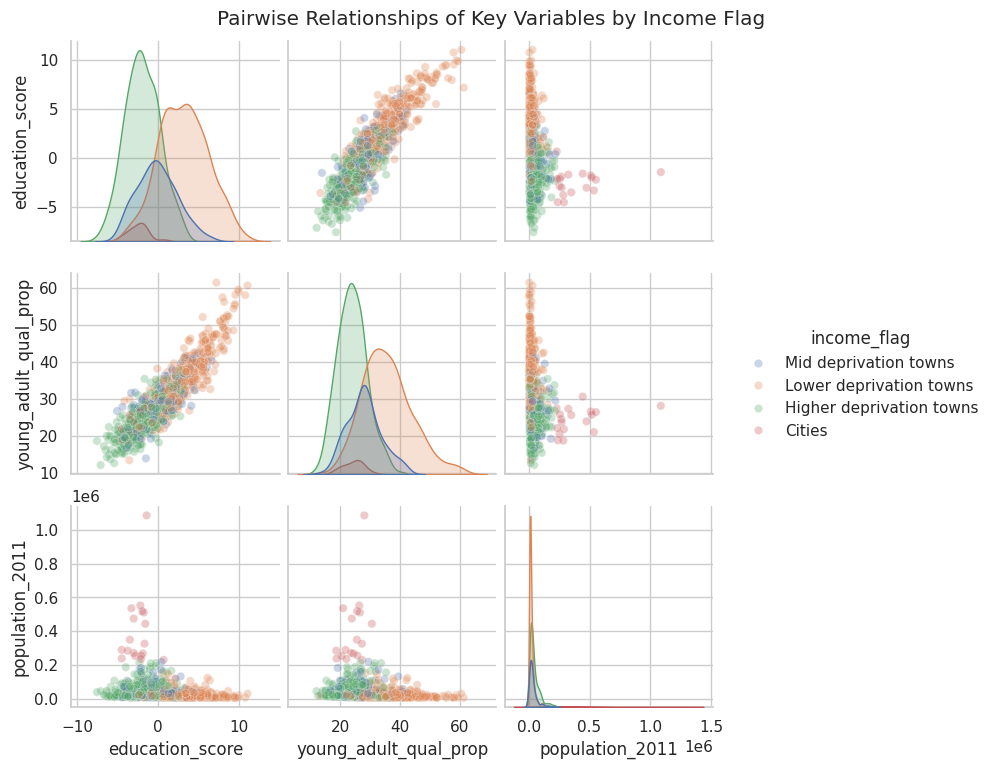

In [13]:
#Dont understand
# 1. Select the key numeric columns we're interested in
pair_vars = [
    'education_score',
    'young_adult_qual_prop',
    'population_2011'
]

# 2. Plot the pairplot
# This might take a few seconds to generate
sns.pairplot(data=clean_data,
             vars=pair_vars,
             hue="income_flag",
             diag_kind="kde", # Show density plots on the diagonal
             plot_kws={'alpha':0.3})

plt.suptitle("Pairwise Relationships of Key Variables by Income Flag", y=1.02)
plt.show()

**Interpretation:**

* This is our "capstone" visualisation. It combines many plots we've already seen.

* **How to Read It:** The plots on the diagonal (`kde`) are the distributions (like `histplot` in Task 1) for each variable, split by `income_flag`. The other plots are scatter plots (like in Task 3) for every combination.

### Conclusion: Your Business Recommendation

**Final Task:** Act as a consultant for the Department for Education. Based on your tasks, what is **one actionable recommendation** you would give?